<a href="https://colab.research.google.com/github/Howl06/practice/blob/main/tensorflow.keras/02_Grad_CAM_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.applications import imagenet_utils
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import os

tf.__version__

'2.12.0'

In [14]:
IMG_SIZE = 299

In [15]:
model = tf.keras.applications.InceptionV3(include_top=True, 
                                          weights='imagenet')

In [16]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

ImageNet class map: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [17]:
def gradcam(model, img, layer_name='conv2d_93', cls_idx=None):
    # get pred class idx
    preds = model.predict(img)
    if cls_idx:
        pred_class_idx = cls_idx # 281: tabby cat
    else:
        pred_class_idx = np.argmax(preds[0])
    # prediction use imagenet_utils get class_name
    pred_decode = imagenet_utils.decode_predictions(preds)[0]
    print(pred_decode)
    print('class_idx: ', pred_class_idx)
    pred_class_name = pred_decode[0][1]

    # build a new model for Grad-CAM
    outputs = [model.get_layer(layer_name).output, 
               model.output]
    model_gradcam = models.Model([model.inputs], outputs) 
    # input: img, output: [layer_output, class_output]
    

    with tf.GradientTape() as tape:
        conv_output, preds = model_gradcam(img)
        pred_output = preds[:, pred_class_idx]
        grads = tape.gradient(pred_output, conv_output) # (H, W, 2048)
        print('conv_output.shape', conv_output.shape)
        print('grads.shape', grads.shape)
    
    pooled_grads = tf.keras.backend.sum(grads, axis=(0, 1, 2)) # (2048, )
    print('pooled_grads.shape ', pooled_grads.shape)
    heatmap = pooled_grads * conv_output
    print('heatmaps.shape ', heatmap.shape)
    heatmap = tf.keras.backend.mean(heatmap, axis=-1)[0, :, :].numpy() # (8, 8)
    
    return heatmap, pred_class_name

In [18]:
def processing_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    # add data in axis=0
    x = np.expand_dims(img, axis=0)
    x = tf.keras.applications.inception_v3.preprocess_input(x)
    return x

In [19]:
def plot_heatmap(heatmap, img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    # ReLU
    heatmap = np.maximum(heatmap, 0)
    
    # normalization
    heatmap /= np.max(heatmap)

    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)

    # show input img
    plt.figure(figsize=(10, 5))    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    # show heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(img) # original img
    plt.imshow(heatmap, cmap='jet', alpha=0.6) # heatmap
    plt.show()

1/1 [==============================] - 0s 153ms/step
[('n03991062', 'pot', 0.35316244), ('n13133613', 'ear', 0.0699775), ('n13044778', 'earthstar', 0.035992224), ('n04522168', 'vase', 0.031780772), ('n12144580', 'corn', 0.023239458)]
class_idx:  738
conv_output.shape (1, 8, 8, 2048)
grads.shape (1, 8, 8, 2048)
pooled_grads.shape  (2048,)
heatmaps.shape  (1, 8, 8, 2048)
pred_class_name:  pot 
 img_path:  /content/drive/MyDrive/團專圖片/test/c016.jpg
heatmap.shape:  (8, 8)


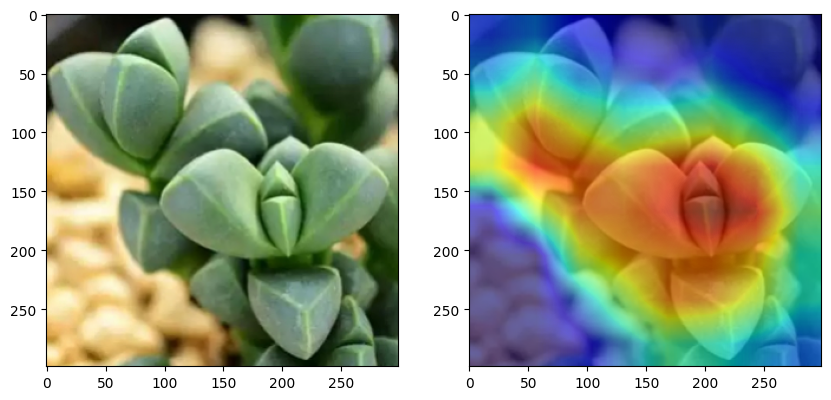

In [38]:
i = random.choice(range(1,4))
FOLDER_PATH = '/content/'
# img_path = os.path.join(FOLDER_PATH, '*.jpeg')
img_path = os.path.join(FOLDER_PATH, "/content/drive/MyDrive/團專圖片/test/c016.jpg")
# img_path = os.path.join(FOLDER_PATH, f'tennis.jpeg')
# img_path = os.path.join(FOLDER_PATH, f'test.png')
# img_path = './test.jpg'

img = processing_image(img_path)
heatmap, pred_class_name = gradcam(model, img, 'mixed10', 
                                   cls_idx=None
                                   ) # conv2d_2 mixed10
print('pred_class_name: ', pred_class_name, '\n img_path: ', img_path)
print('heatmap.shape: ', heatmap.shape)
plot_heatmap(heatmap, img_path)